In [ ]:
#import libraries
import numpy as np
import pickle as pkl
from torchvision.models import resnet50
from sklearn.neighbors import NearestNeighbors

import scipy.io as sio
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import torch.nn as nn
import zipfile
import torchvision.transforms as tf
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import os



In [ ]:
# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/finalproject_DL/'
results_path = '/content/drive/MyDrive/finalproject_DL/Results/'


Mounted at /content/drive


In [ ]:
model = resnet50(pretrained=True)

# Remove the fully connected layer (classification layer)
modules = list(model.children())[:-1]
model = torch.nn.Sequential(*modules)

# Set the model to evaluation mode
model.eval()

# Set all parameters to be non-trainable
for param in model.parameters():
    param.requires_grad = False


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s]


In [ ]:
def read_images_from_directory(directory_path):
    image_files = []
    for filename in os.listdir(directory_path):
          image_files.append(os.path.join(directory_path, filename))
    return image_files

images = read_images_from_directory(data_path + "images/")

KeyboardInterrupt: 

In [ ]:
import os
filenames = []
for file in os.listdir(data_path + 'images/'):
    filenames.append(os.path.join('images',file))

# Example usage
print(len(filenames))

7082


In [ ]:
# Compose a series of transformations that will be applied to the images
tr = tf.Compose([
    tf.Resize((224, 224)),
    tf.Grayscale(num_output_channels=3),  # Convert to 3 channels (RGB)
    tf.ToTensor(),  # Converts an image loaded in range [0, 255] to a torch.Tensor in range [0.0, 1.0]
    tf.Normalize(mean= [0.485, 0.456, 0.406] , std=[0.229, 0.224, 0.225]),  # Normalizes using imageNet mean, std values
])

In [ ]:

def extract_features_from_images(image_path, model, tr):

    img = Image.open(image_path)
    img = tr(img).unsqueeze(0)  # Add a batch dimension
    #display(tf.ToPILImage()(img.squeeze(0)))

    # Extract features using the model
    with torch.no_grad():
        features = model(img)

    # Flatten the features tensor
    flattened_features = features.flatten()

    # Normalize the features
    norm_features = flattened_features / torch.norm(flattened_features)

    return norm_features



In [ ]:
feat1 = extract_features_from_images(data_path + filenames[0], model, tr)
print(feat1.shape)

KeyboardInterrupt: 

In [ ]:
image_features = []
for img in filenames:
  feature = extract_features_from_images(data_path + img, model, tr)
  image_features.append(feature)

In [ ]:
image_features = pkl.dump(image_features, open('Images_features.pkl','wb'))

In [ ]:
file_path = os.path.abspath('Images_features.pkl')
print("The file will be stored at:", file_path)

The file will be stored at: /content/Images_features.pkl


In [ ]:
filenames = pkl.dump(filenames, open('filenames.pkl','wb'))

NameError: name 'filenames' is not defined

In [ ]:
Image_features = pkl.load(open(results_path+'Images_features.pkl','rb'))

In [ ]:
filenames = pkl.load(open(results_path+'filenames.pkl','rb'))

In [ ]:
neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')

In [ ]:
neighbors.fit(Image_features)

NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=6)

In [ ]:
input_image = extract_features_from_images(data_path+'images/1163.jpg',model,tr)

In [ ]:
distance,indices = neighbors.kneighbors([input_image])

In [ ]:
from IPython.display import Image as image

In [ ]:
def display_recommended_images(indices, filenames, data_path):
    for index in indices:
        display(image(filename=data_path+filenames[index]))

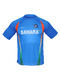

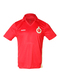

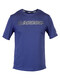

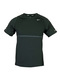

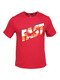

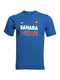

In [ ]:
display_recommended_images(indices[0], filenames, data_path)

**K neighbours**

Euclidean distance (cambiar distancias)


Manhattan distance


In [ ]:
neighbors2 = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='manhattan')

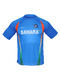

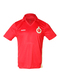

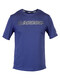

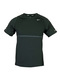

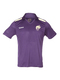

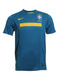

In [ ]:
neighbors2.fit(Image_features)
input_image = extract_features_from_images(data_path+'images/1163.jpg',model,tr)
distance,indices = neighbors2.kneighbors([input_image])
display_recommended_images(indices[0], filenames, data_path)

Cosine distance

In [ ]:
neighbors3 = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='cosine')

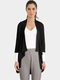

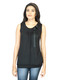

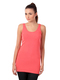

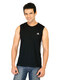

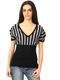

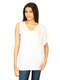

In [ ]:
neighbors3.fit(Image_features)
input_image = extract_features_from_images(data_path+'images/1165.jpg',model,tr)
distance,indices = neighbors3.kneighbors([input_image])
display_recommended_images(indices[0], filenames, data_path)

**Cosine sim**

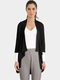

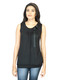

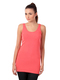

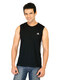

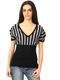

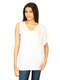

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

input_image = extract_features_from_images(data_path+'images/1165.jpg',model,tr)

distances = cosine_similarity([input_image], Image_features)
indices = np.argsort(distances[0])[-6:][::-1]  # Los 6 más similares

display_recommended_images(indices, filenames, data_path)